In [1]:
import os
import sys
import pandas as pd
import polars as pl
import numpy as np
import json
import random
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit, cross_validate


# root path
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the Python path
if ROOT not in sys.path:
    sys.path.append(ROOT)

from src.data.data_processing import FraudPreProcessor

import warnings
warnings.filterwarnings('ignore')

In [2]:
def pickelup_client_data(file_path):
    client_df = pd.read_pickle(file_path)
    return client_df

def pickelup_card_data(file_path):
    card_df = pd.read_pickle(file_path)
    return card_df

def query_unique_id(df, unique_id=None, target_col='y'):
    """Filters a DataFrame by unique_id (or a random one) and plots the resulting time series."""
    # Select random client if none specified
    unique_id = unique_id or random.choice(df['unique_id'].unique())
    
    # Filter dataframe
    query_df = df[df['unique_id'] == unique_id]
    
    if not query_df.empty:
        plt.figure(figsize=(10, 6))
        # Correct way to plot using DataFrame
        plt.plot(query_df['ds'], query_df[target_col])
        
        # Add labels and title
        plt.title(f'Time Series for Client {unique_id}')
        plt.xlabel('Date')
        plt.ylabel(target_col)
        
        # Rotate x-axis labels for better readability
        plt.xticks(rotation=45)
        
        # Adjust layout to prevent label cutoff
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for unique_id: {unique_id}")
    
    return query_df

In [3]:
DATA_PATH = os.path.join(ROOT, 'data', 'raw', 'transactions_data.csv')
CLIENT_DATA_PATH = os.path.join(ROOT, 'data', 'processed', 'client_df.pkl')

PREDICTION_IDS_PATH = os.path.join(ROOT, 'predictions', 'predictions_4.json')

CLEAN_DATA_PATH = os.path.join(ROOT, 'data', 'processed', 'forecast_clean.csv')
CLEAN_CLIENT_PATH = os.path.join(ROOT, 'data', 'processed', 'client_clean.pkl')

# Check client 1649

Segun submission:

```
"1649": {
            "2019-11": 0,
            "2019-12": 0,
            "2020-01": 0
```

Segun yo:

```
"1649": {
      "2015-10": 36.78,
      "2015-11": 35.85,
      "2015-12": 40.09
    },

In [ ]:
raw = pl.read_csv(DATA_PATH).to_pandas().rename(columns={'date': 'ds', 
                'amount_clean': 'y',
                'client_id': 'unique_id'})

In [10]:
raw.query('unique_id == 1649')['ds'].sort_values()

8808        2010-01-03 15:45:00
9748        2010-01-03 23:37:00
12812       2010-01-04 21:18:00
24405       2010-01-08 12:44:00
34415       2010-01-11 13:21:00
                   ...         
13271395    2019-10-22 19:54:00
13273698    2019-10-23 13:28:00
13290859    2019-10-27 23:38:00
13293086    2019-10-28 13:22:00
13298096    2019-10-29 21:08:00
Name: ds, Length: 2336, dtype: object

In [16]:
transactions, _ = FraudPreProcessor().pl_load_transactions_data(DATA_PATH)
transactions = transactions.with_columns(pl.col('client_id').cast(pl.Int64).alias('client_id'))

# NOT FILTER. Load all data but replace incomes for 0 expenses
expenses = transactions.with_columns(pl.when(pl.col('amount_clean') > 0).then(0).otherwise(pl.col('amount_clean')).alias('amount_clean')).to_pandas()
expenses

Processing transactions data...


,client_id,amount_clean,date
0,1556,-77.0,2010-01-01 00:01:00
1,561,0.0,2010-01-01 00:02:00
2,1129,0.0,2010-01-01 00:02:00
3,430,0.0,2010-01-01 00:05:00
4,848,0.0,2010-01-01 00:06:00
...,...,...,...
13305910,1718,0.0,2019-10-31 23:56:00
13305911,1766,0.0,2019-10-31 23:56:00
13305912,199,0.0,2019-10-31 23:57:00
13305913,1986,0.0,2019-10-31 23:58:00


In [17]:
expenses.query('client_id == 1649').sort_values('date')

,client_id,amount_clean,date
8808,1649,0.0,2010-01-03 15:45:00
9748,1649,0.0,2010-01-03 23:37:00
12812,1649,0.0,2010-01-04 21:18:00
24405,1649,0.0,2010-01-08 12:44:00
34415,1649,0.0,2010-01-11 13:21:00
...,...,...,...
13271395,1649,0.0,2019-10-22 19:54:00
13273698,1649,0.0,2019-10-23 13:28:00
13290859,1649,0.0,2019-10-27 23:38:00
13293086,1649,0.0,2019-10-28 13:22:00


### Compare unique ids with submission file

In [18]:
with open(PREDICTION_IDS_PATH, 'r') as f:
    predictions_template = json.load(f)

In [19]:
def json_to_df(data):
    """
    Convert nested JSON with structure:
    {'target': {'id1': {'date1': value1, 'date2': value2}, 'id2': {...}}}
    to DataFrame with columns: unique_id, date, value
    """
    rows = []
    
    # Iterate through the nested structure
    for unique_id, dates in data['target'].items():
        for date, value in dates.items():
            rows.append({
                'unique_id': unique_id,
                'date': pd.to_datetime(date),  # Convert to datetime
                'value': value
            })
    
    # Create DataFrame from rows
    df = pd.DataFrame(rows)
    
    # Sort by date and unique_id
    df = df.sort_values(['date', 'unique_id'])
    
    return df

predictions_template_df = json_to_df(predictions_template)

In [20]:
print(f"Number of unique ids: {predictions_template_df['unique_id'].nunique()}\n")
print(f"Number of dates: {predictions_template_df['date'].nunique()}\n")
print(f"Range of dates: {predictions_template_df['date'].min()} to {predictions_template_df['date'].max()}\n")
submission_ids = set(predictions_template_df['unique_id'].unique())

Number of unique ids: 1219

Number of dates: 52

Range of dates: 2013-02-01 00:00:00 to 2020-01-01 00:00:00



In [21]:
print(f"Number of unique ids: {expenses['client_id'].nunique()}\n")
print(f"Number of dates: {expenses['date'].nunique()}\n")
print(f"Range of dates: {expenses['date'].min()} to {expenses['date'].max()}\n")
expenses_ids = set(expenses['client_id'].astype(str).unique())

Number of unique ids: 1219

Number of dates: 4136496

Range of dates: 2010-01-01 00:01:00 to 2019-10-31 23:59:00



In [22]:
expenses_ids.difference(submission_ids)

set()

In [23]:
submission_ids.difference(expenses_ids)

set()

### Resample data to month

In [24]:
data = (
    expenses.sort_values(by=['client_id', 'date'])
    .set_index('date')
    .groupby('client_id')
    .resample('ME')['amount_clean']
    .sum()
    .reset_index()
).rename(columns={'date': 'ds', 
                'amount_clean': 'y',
                'client_id': 'unique_id'})

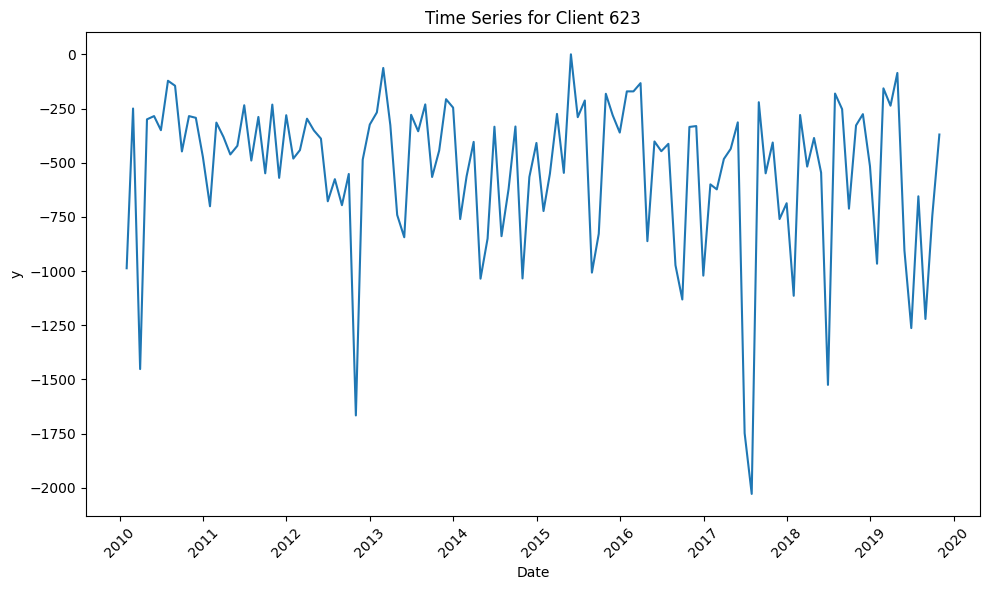

,unique_id,ds,y
42855,623,2010-01-31,-987.0
42856,623,2010-02-28,-250.0
42857,623,2010-03-31,-1452.0
42858,623,2010-04-30,-300.0
42859,623,2010-05-31,-285.0
...,...,...,...
42968,623,2019-06-30,-1263.0
42969,623,2019-07-31,-655.0
42970,623,2019-08-31,-1221.0
42971,623,2019-09-30,-745.0


In [25]:
query_unique_id(data, unique_id=0)

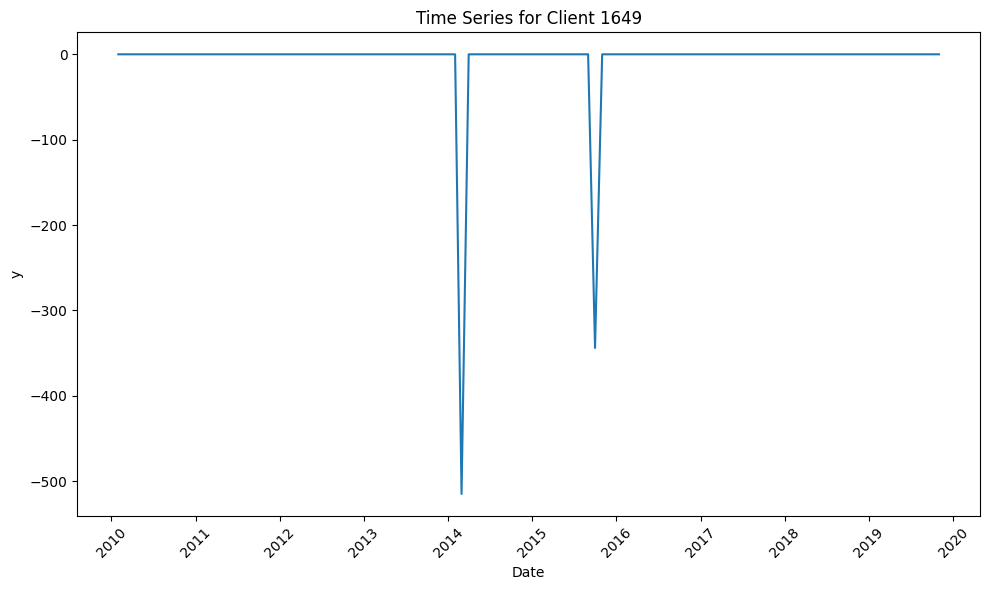

,unique_id,ds,y
115330,1649,2010-01-31,0.0
115331,1649,2010-02-28,0.0
115332,1649,2010-03-31,0.0
115333,1649,2010-04-30,0.0
115334,1649,2010-05-31,0.0
...,...,...,...
115443,1649,2019-06-30,0.0
115444,1649,2019-07-31,0.0
115445,1649,2019-08-31,0.0
115446,1649,2019-09-30,0.0


In [26]:
query_unique_id(data, unique_id=1649)

In [27]:
import random

def check_unique_dates(df):
    # Count unique dates for each client
    unique_dates = data.groupby('unique_id')['ds'].nunique()
    return unique_dates

amount_months = check_unique_dates(data)
amount_months.describe()

count    1219.000000
mean      114.803938
std        11.832511
min        28.000000
25%       118.000000
50%       118.000000
75%       118.000000
max       118.000000
Name: ds, dtype: float64

### Save data

In [28]:
data.to_csv(CLEAN_DATA_PATH, index=False)

# Extra client data as static features

In [4]:
data = pd.read_csv(CLEAN_DATA_PATH, parse_dates=['ds'])
data.head()

,unique_id,ds,y
0,0,2010-01-31,-436.0
1,0,2010-02-28,-470.0
2,0,2010-03-31,-803.0
3,0,2010-04-30,-235.0
4,0,2010-05-31,-290.0


In [5]:
clients = pd.read_pickle(CLIENT_DATA_PATH)
clients.head()

,client_id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.0,-118.0,29278,59696,127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,41.0,-74.0,37891,77254,191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.0,-118.0,22681,33483,196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,41.0,-74.0,163145,249925,202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,38.0,-122.0,53797,109687,183855,675,1


In [7]:
clients['gender'] = np.where(clients['gender'] == 'Female', 1, 0)

int_cols = [
    'client_id',
 'current_age',
 'retirement_age',
 'birth_year',
 'birth_month',
 'gender',
 'per_capita_income',
 'yearly_income',
 'total_debt',
 'credit_score',
 'num_credit_cards'
]

for col in int_cols:
    clients[col] = clients[col].astype(int)

Are there extra clients?

In [10]:
clients_ids = set(clients['client_id'].astype(str).unique())
transactions_clients_ids = set(data['unique_id'].astype(str).unique())

print(f"Number of unique ids: {clients['client_id'].nunique()}\n")
print(f"Number of transactions: {data['unique_id'].nunique()}\n")

print(f"Number of not common ids: {len(clients_ids.difference(transactions_clients_ids))}")

Number of unique ids: 2000

Number of transactions: 1219

Number of not common ids: 781


In [11]:
common_ids = list(clients_ids.intersection(transactions_clients_ids))
print(clients.shape)
clients = clients[clients['client_id'].astype(str).isin(common_ids)]
clients = clients.drop('address', axis=1)
print(clients.shape)

(2000, 14)
(1219, 13)


In [12]:
clients.to_pickle(CLEAN_CLIENT_PATH)